In [9]:
# Section must be included at the beginning of each new notebook. Remember to change the app name.
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip3 install numpy --user' into the console.
# If you're getting an error with another package, type 'sudo pip3 install PACKAGENAME --user'. 
# Replace PACKAGENAME with the relevant package (such as pandas, etc).
from pyspark.ml.regression import LinearRegression

# First, let's import the data. Note that we can infer the schema as it's a CSV file.
df = spark.read.csv("Datasets/IVS_Country.csv",inferSchema=True,header=True)

In [10]:
# Let's explore. Here's the first row of the data.
print(df.head())

# And the entire data structure. 
df.printSchema()

Row(Pkey=1, Year=1997, Quarter=4, Year ending='YEDec 1997', Airport of departure='Auckland', Purpose of visit='Business', Country of permanent residence='Africa and Middle East', Total visitor spend=4266524.07, Total visitors=1684)
root
 |-- Pkey: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Year ending: string (nullable = true)
 |-- Airport of departure: string (nullable = true)
 |-- Purpose of visit: string (nullable = true)
 |-- Country of permanent residence: string (nullable = true)
 |-- Total visitor spend: double (nullable = true)
 |-- Total visitors: integer (nullable = true)



In [11]:
# Oops! Forgot to assign the result to a variable. Let's try that again. Now you can see that records with null values have been removed.
df = df.na.drop()
df.show()
print("Total data points:", df.count())

+----+----+-------+-----------+--------------------+------------------+------------------------------+-------------------+--------------+
|Pkey|Year|Quarter|Year ending|Airport of departure|  Purpose of visit|Country of permanent residence|Total visitor spend|Total visitors|
+----+----+-------+-----------+--------------------+------------------+------------------------------+-------------------+--------------+
|   1|1997|      4| YEDec 1997|            Auckland|          Business|          Africa and Middle...|         4266524.07|          1684|
|   2|1997|      4| YEDec 1997|            Auckland|          Business|                     Australia|      1.325885058E8|         67277|
|   3|1997|      4| YEDec 1997|            Auckland|          Business|                        Canada|      1.558969421E7|          3596|
|   4|1997|      4| YEDec 1997|            Auckland|          Business|                         China|         9490117.52|          4510|
|   5|1997|      4| YEDec 1997|   

In [12]:
# Now that we understand the data's features, let's use a Python package to neatly describe the data.
import pandas as pd
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pkey,11292,8609.705897980872,4917.03995600964,1,17056
Year,11292,2007.9382748848743,5.880289393162935,1997,2018
Quarter,11292,2.4991144172865747,1.1292752985276613,1,4
Year ending,11292,None,None,YEDec 1997,YESep 2017
Airport of departure,11292,None,None,Auckland,Wellington
Purpose of visit,11292,None,None,Business,Visiting friends / relatives
Country of permanent residence,11292,None,None,Africa and Middle East,USA
Total visitor spend,11292,5.09246119696264E7,1.0193863986366412E8,2.4,1.235333092E9
Total visitors,11292,15576.741232731138,33229.303734004156,1,314584


In [25]:
# Import VectorAssembler and Vectors
from pyspark.ml.feature import VectorAssembler

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
vector_assembler = VectorAssembler(inputCols = ['Pkey', 'Year', 'Quarter', 'Total visitor spend'], outputCol = 'features')

# Now that we've created the assembler variable, let's actually transform the data.
vector_output = vector_assembler.transform(df)

# Using print schema, you see that the features output column has been added. 
vector_output.printSchema()

# You can see that the features column is a DenseVector that combines the various features as expected.
vector_output.head(1)

root
 |-- Pkey: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Year ending: string (nullable = true)
 |-- Airport of departure: string (nullable = true)
 |-- Purpose of visit: string (nullable = true)
 |-- Country of permanent residence: string (nullable = true)
 |-- Total visitor spend: double (nullable = true)
 |-- Total visitors: integer (nullable = true)
 |-- features: vector (nullable = true)



[Row(Pkey=1, Year=1997, Quarter=4, Year ending='YEDec 1997', Airport of departure='Auckland', Purpose of visit='Business', Country of permanent residence='Africa and Middle East', Total visitor spend=4266524.07, Total visitors=1684, features=DenseVector([1.0, 1997.0, 4.0, 4266524.07]))]

In [26]:
# Because the features have been combined into one vector, we no longer need them. Below we select the features and label.
vector_output = vector_output.select(['features', 'Total visitors'])

# You can see that the dataframe now only contains two columns. 
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([1.0, 1997.0, 4.0, 4266524.07]), Total visitors=1684)]
+--------------------+--------------+
|            features|Total visitors|
+--------------------+--------------+
|[1.0,1997.0,4.0,4...|          1684|
|[2.0,1997.0,4.0,1...|         67277|
|[3.0,1997.0,4.0,1...|          3596|
+--------------------+--------------+
only showing top 3 rows



In [27]:
# Let's do a randomised 70/30 split. Remember, you should explain why you chose a particular split. 
train_data,test_data = vector_output.randomSplit([0.7,0.3])

# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+-----------------+
|summary|   Total visitors|
+-------+-----------------+
|  count|             7894|
|   mean|15437.14884722574|
| stddev|33203.63727313209|
|    min|                1|
|    max|           308902|
+-------+-----------------+

+-------+-----------------+
|summary|   Total visitors|
+-------+-----------------+
|  count|             3398|
|   mean|15901.03266627428|
| stddev|33291.48581995839|
|    min|                7|
|    max|           314584|
+-------+-----------------+



In [28]:
# Importing the LR package.
from pyspark.ml.regression import LinearRegression

# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='Total visitors')

# Fit the training data.
lr_model = lr.fit(train_data)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
training_summary = lr_model.summary

# Print RMSE. 
print("RMSE: " + str(training_summary.rootMeanSquaredError))

# Print R2.
print("R2: " + str(training_summary.r2))

Coefficients: [-0.014964170917972204,138.1663716533955,-18.754425154271107,0.00029266863956557145]
Intercept: -276634.4927194045

RMSE: 14127.809627590108
R2: 0.8189354765854702


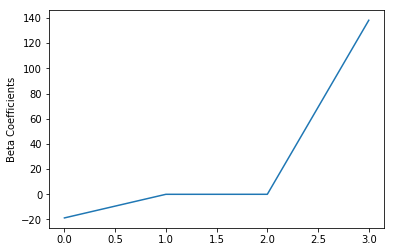

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

In [30]:
train_data.describe().show()

+-------+-----------------+
|summary|   Total visitors|
+-------+-----------------+
|  count|             7894|
|   mean|15437.14884722574|
| stddev|33203.63727313209|
|    min|                1|
|    max|           308902|
+-------+-----------------+



In [31]:
# Let's evaluate the model against the test data.
test_results = lr_model.evaluate(test_data)

# And print the RMSE/R2. As expected, our RMSE and R2 are slightly worse when applying the testing set.
print("RMSE on test data: " + str(test_results.rootMeanSquaredError))
print("R2 on test data: " + str(test_results.r2))

RMSE on test data: 14399.646746629594
R2 on test data: 0.812860636953208
